In [1]:
using DifferentialEquations
using ReactionMechanismSimulator
using PyPlot

In [2]:
outdict = readinput("chem300.rms")

[14:28:08] WARNING: not removing hydrogen atom without neighbors
[14:28:08] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [3]:
boundarylayerspcs = outdict["gas"]["Species"]
boundarylayerrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [4]:
sitedensity = 2.292e-5; # Ag111
boundarylayer = IdealDiluteSolution(boundarylayerspcs,boundarylayerrxns,solv,name="boundarylayeruid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [5]:
initialcondsboundarylayer = Dict(["proton"=>10.0^-4,
                                  "CO2"=>10.0^-3*10^6,
                                  "V"=>1.0e-3,"T"=>300,"Phi"=>0.0,"d"=>0.0]);
initialcondsreservoir = Dict(["proton"=>10.0^-4,
                              "CO2"=>10.0^-3*10^6,
                              "V"=>1.0,"T"=>300]);
AVratio = 1e5;
initialcondssurf = Dict(["CO2X"=>0.4*sitedensity*AVratio,
        "CHO2X"=>0.1*sitedensity*AVratio,
        "CO2HX"=>0.1*sitedensity*AVratio,
        "OX"=>0.1*sitedensity*AVratio,
        "OCX"=>0.1*sitedensity*AVratio,
        "vacantX"=>0.1*sitedensity*AVratio,
        "CH2O2X"=>0.05*sitedensity*AVratio,
        "CHOX"=>0.04*sitedensity*AVratio,
        "CH2OX"=>0.01*sitedensity*AVratio,
        "A"=>1.0*AVratio,"T"=>300,"Phi"=>-1.0]);

In [6]:
domainboundarylayer, y0boundarylayer, pboundarylayer = ConstantTVDomain(phase=boundarylayer, initialconds=initialcondsboundarylayer);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [7]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainboundarylayer,
  domaincat,interfacerxns,298.15,AVratio*1.0);

In [8]:
# start with 1mm layer thickness
diffusionlayer = ConstantReservoirDiffusion(domainboundarylayer, initialcondsreservoir, AVratio*1.0, 1e-3);

In [9]:
interfaces = [inter, diffusionlayer];

In [10]:
@time react,y0,p = Reactor((domainboundarylayer,domaincat), (y0boundarylayer,y0cat), (0.0, 1.0e2), interfaces, (pboundarylayer,pcat,pinter));


 17.594306 seconds (76.53 M allocations: 4.854 GiB, 7.88% gc time, 99.49% compilation time: <1% of which was recompilation)


In [11]:
@time sol = solve(react.ode,DifferentialEquations.CVODE_BDF(),abstol=1e-16,reltol=1e-8);

 14.018329 seconds (45.39 M allocations: 14.701 GiB, 8.17% gc time, 63.16% compilation time)


In [12]:
sol

retcode: Success
Interpolation: 3rd order Hermite
t: 7378-element Vector{Float64}:
   0.0
   5.637182922368118e-20
   1.1274365844736235e-19
   2.8910211211279163e-19
   4.654605657782209e-19
   6.418190194436502e-19
   9.195383720242527e-19
   1.3841882991386121e-18
   2.1843751517941395e-18
   3.563281809146959e-18
   ⋮
  34.585534778618225
  37.972824443061896
  41.36011410750557
  48.6159125226287
  55.87171093775183
  63.12750935287496
  70.38330776799809
  83.73929891807829
 100.0
u: 7378-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 1000.0, 0.0001, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 1000.0, 0.0001, 0.0, 0.0, 0.0, 0.0  …  3.616585260471062e-48, 1.250284183589301e-66, 3.3559035931055214e-86, -2.930822829419953e-183, 9.11712362429275e-74, 4.972280466767057e-91, 1.6800515466000932e-93, 8.919271365980456e-98, 5.278931575090823e-45, 1.995290567657646e-61]
 [0.0, 0.0, 0.0, 0.0, 1000.0, 0.0001, 0.0, 0.0, 0.0, 0.0  …  1

In [13]:
sol.retcode

ReturnCode.Success = 1

In [14]:
ssys = SystemSimulation(sol,(domainboundarylayer,domaincat,), interfaces,p);

In [15]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [16]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

In [17]:
concentrations(ssys.sims[1])

108×7378 Matrix{Float64}:
 0.0    0.0    0.0    0.0    0.0    0.0    …     0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0          0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0          0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0          0.0             0.0
 1.0e6  1.0e6  1.0e6  1.0e6  1.0e6  1.0e6     1000.0          1000.0
 0.1    0.1    0.1    0.1    0.1    0.1    …     0.0001          0.0001
 0.0    0.0    0.0    0.0    0.0    0.0          0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0          1.26634e-25    -3.37894e-24
 0.0    0.0    0.0    0.0    0.0    0.0         -3.85013e-25     3.87315e-23
 0.0    0.0    0.0    0.0    0.0    0.0          4.98977e-32     5.14795e-31
 ⋮                                  ⋮      ⋱                  
 0.0    0.0    0.0    0.0    0.0    0.0          0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0    …     0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0          0.0    

In [18]:
concentrations(ssys.sims[2])

192×7378 Matrix{Float64}:
 2.292e-6   2.292e-6      2.292e-6      …   1.18178e-9    1.1809e-9
 9.168e-6   9.168e-6      9.168e-6          2.13269e-6    2.13112e-6
 2.292e-6   2.292e-6      2.292e-6          3.01776e-11   3.01567e-11
 2.292e-6   2.292e-6      2.292e-6          2.23002e-11   2.22837e-11
 2.292e-6   2.292e-6      2.292e-6          1.74681e-11   1.74554e-11
 2.292e-6   2.292e-6      2.292e-6      …   3.69096e-17   3.69068e-17
 1.146e-6   1.146e-6      1.146e-6          1.6834e-5     1.68134e-5
 9.168e-7   9.168e-7      9.168e-7          1.67247e-10   1.67135e-10
 2.292e-7   2.292e-7      2.292e-7          5.85808e-9    5.85419e-9
 0.0        3.93893e-14   7.87785e-14       7.35377e-19   7.35366e-19
 ⋮                                      ⋱                
 0.0        1.25028e-71   8.74148e-71       1.11796e-24   1.11613e-24
 0.0        3.3559e-91    1.9748e-90        3.87397e-29   3.86904e-29
 0.0       -2.93082e-188  3.21592e-180  …  -1.60967e-81  -1.50788e-81
 0.0       

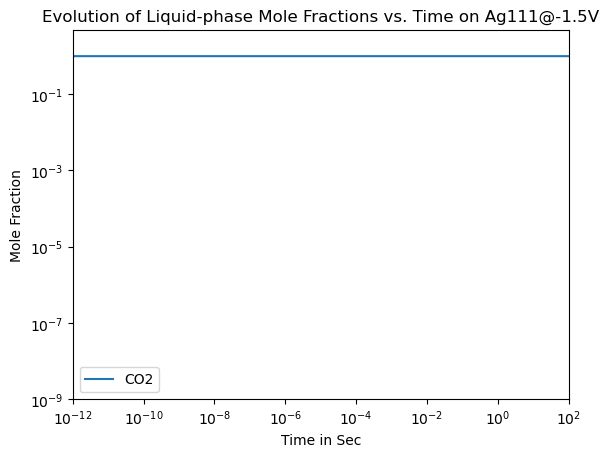

In [19]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-6, 1e2, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e2)
ylim(1e-9, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

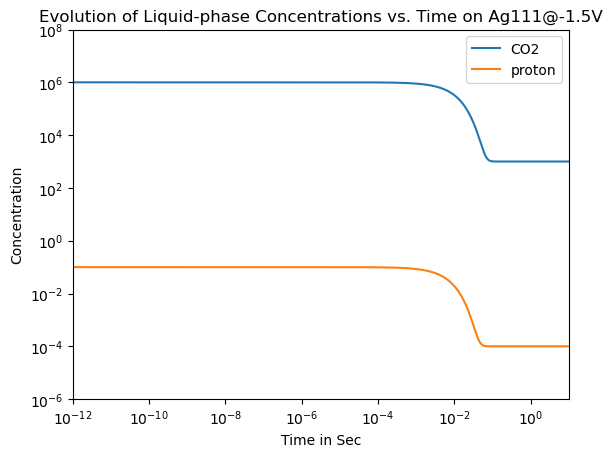

In [20]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-6, 1e2, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 10)
ylim(1e-6, 1e8)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

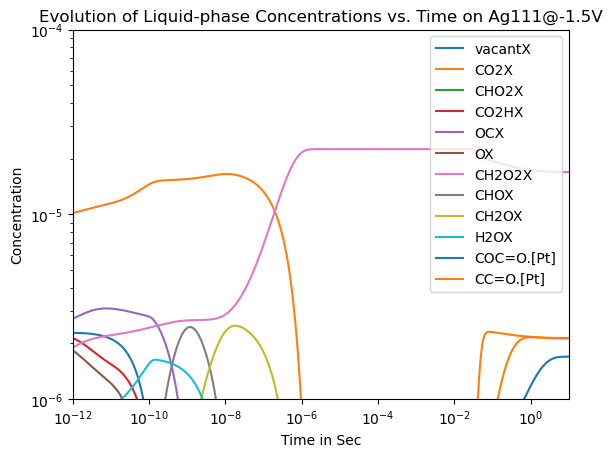

In [21]:
exclude_species = ["H2O"]
plotC(ssys.sims[2], 1e-6, 1e2, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 10)
ylim(1e-6, 1e-4)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

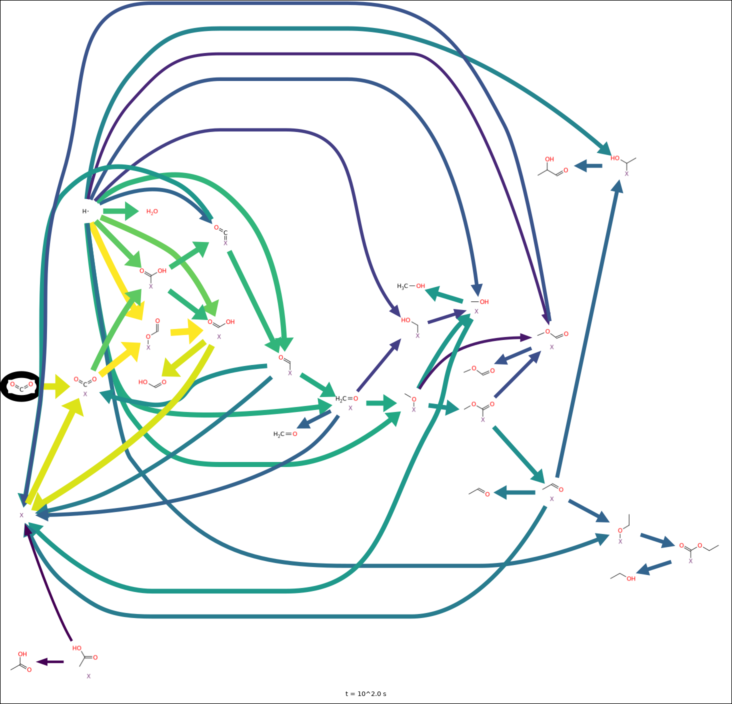

In [22]:
getfluxdiagram(ssys,1e2;speciesratetolerance=1e-6)

In [23]:
println(ssys.names)

["Ar", "He", "Ne", "N2", "CO2", "proton", "H", "C=O", "O=CO", "H2O", "O=CC=O", "H2", "OO", "CO", "O2", "O=C=C=O", "C=C=O", "O=C=CO", "CH4", "COC=O", "COO", "CO-2", "COOC", "O=CCO", "OCO", "COCO", "OCCO", "OC=CO", "O=O", "C=CO", "C=C", "O=C=C=C=O", "C#COO[CH2]", "C#COC[O]", "CC=O", "O=C=CC=O", "C=C(O)O", "CC(=O)O", "[OH]", "CC(=O)C=O", "COC(C)=O", "CC(=O)CO", "O=CCC=O", "COC=C=O", "O=C=CCO", "[CH2]OOC=C", "C=COC[O]", "C=CC=O", "C=COC=O", "O=CC=CO", "COC", "CCO", "CC(O)O", "CCOC=O", "COCC=O", "CCOO", "CC(C)=O", "C=C=C=O", "CC=C=O", "CC", "O=C=C=CO", "[CH2]OCC=O", "[O]CCC=O", "[CH2]COC=O", "[CH3]", "O=CCCO", "CCC=O", "CC(O)=C=O", "[CH]=O", "C[O]", "CC(O)C=O", "[CH2]O", "C=C(O)C=O", "OC=CCO", "C=CCO", "[CH]=C", "C[CH2]", "C=C=CO", "C=C=C", "C=C=C(O)O", "C=CC(=O)O", "CC=CO", "C=CC", "CC=C(O)O", "CCC(=O)O", "C=COO", "C#C", "C=COC", "C=CC(O)O", "C=COCO", "C=CCOO", "C=COOC", "CC(O)=CO", "C=C(C)O", "C#CC=O", "OC=C=CO", "CCOC", "CCCO", "CCC(O)O", "CCOCO", "CCCOO", "CCC", "CCOOC", "C=C=COO", "CC=

In [24]:
plotrops(ssys,"CH2O2X",1;N=15,tol=0.0)

In [25]:
plotrops(ssys,"CHO2X",1;N=10,tol=0.0)

In [26]:
plotrops(ssys,"CO2HX",1;N=10,tol=0.0)

In [27]:
plotrops(ssys,"OX",1;N=10,tol=0.0)

In [28]:
plotrops(ssys,"OCX",1.0e-6)

In [29]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 20654.615923781494
krev = 11189.298481041604
Kc = 1.8459259048971917
proton+CO2X<=>CHO2X
kf = 5.164749496653815e7
krev = 3.369038128826839e8
Kc = 0.1533004168893831
proton+CO2X<=>CO2HX
kf = 463658.8965294065
krev = 1.20318988446587e-5
Kc = 3.853580407511801e10
proton+CHO2X<=>CH2O2X
kf = 2.5e10
krev = 9.108706843764319e-26
Kc = 2.7446266993557504e35
proton+CO2HX<=>CH2O2X
kf = 1.9190551016885178e10
krev = 1.757621070775451e-14
Kc = 1.0918480289052538e24
proton+OCX<=>CHOX
kf = 2.5e10
krev = 2.604453583293511e-10
Kc = 9.59894242706594e19
proton+CHOX<=>CH2OX
kf = 1.7890196451453958e9
krev = 4.957912234830633e-11
Kc = 3.608413300616868e19
vacantX+vacantX+CO2<=>OX+OCX
kf = 3.0109478093923404e-24
krev = 3.037156297092479e15
Kc = 9.913707148607306e-40
OX+proton<=>HOX
kf = 2.5e10
krev = 4.7547181516587526e-14
Kc = 5.25793521352646e23
vacantX+C=O<=>CH2OX
kf = 500114.13488002896
krev = 399.6803280141717
Kc = 1251.2853393732605
proton+CHO2X<=>OX+C=O
kf = 7.971946163368602e-7

In [30]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 20654.615923781494
krev = 11189.298481041604
Kc = 1.8459259048971917
proton+CO2X<=>CHO2X
kf = 5.164749496653815e7
krev = 3.369038128826839e8
Kc = 0.1533004168893831
proton+CO2X<=>CO2HX
kf = 463658.8965294065
krev = 1.20318988446587e-5
Kc = 3.853580407511801e10
proton+CHO2X<=>CH2O2X
kf = 2.5e10
krev = 9.108706843764319e-26
Kc = 2.7446266993557504e35
proton+CO2HX<=>CH2O2X
kf = 1.9190551016885178e10
krev = 1.757621070775451e-14
Kc = 1.0918480289052538e24
proton+OCX<=>CHOX
kf = 2.5e10
krev = 2.604453583293511e-10
Kc = 9.59894242706594e19
proton+CHOX<=>CH2OX
kf = 1.7890196451453958e9
krev = 4.957912234830633e-11
Kc = 3.608413300616868e19
vacantX+vacantX+CO2<=>OX+OCX
kf = 3.0109478093923404e-24
krev = 3.037156297092479e15
Kc = 9.913707148607306e-40
OX+proton<=>HOX
kf = 2.5e10
krev = 4.7547181516587526e-14
Kc = 5.25793521352646e23
vacantX+C=O<=>CH2OX
kf = 500114.13488002896
krev = 399.6803280141717
Kc = 1251.2853393732605
proton+CHO2X<=>OX+C=O
kf = 7.971946163368602e-7